# Color based NDT processing demonstration (trial run)

In [1]:
# Using 2D projection map generated from <color_NDT_preprocessing.ipynb> 
# Attempting initial implementation of color based NDT

Checklist 
1. [x] 2D projection map creation
2. [x] Satellite image scaling
3. [x] Common coordinte frame with initial guess
4. [x] Define bins along coordinate frame
5. [x] Distribute reference map points in corresponding bins
6. [x] Distribute satellite image points in corresponding bins
7. [x] Define distributions within each voxel
8. [ ] Define gradient data within each voxel 

Other things to do:
1. [ ] Come up with a better acronym than color based NDT (if it works)
2. [ ] Revisit scaling methods

In [2]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import imageio
from scipy.spatial.transform import Rotation as R

# If necessary 
from groundNAV_utils import * 
from colmapParsingUtils import *

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [3]:
# Load in reference map and satellite image 
ref_scene = np.load('Data_arrays/turf_colmap_2d_proj.npy')
ref_rgb = np.load('Data_arrays/turf_colmap_2d_rgb.npy')
sat_im = cv2.imread('TTurf/TurfSat.jpg')
sat_im_crop = cv2.imread('TTurf/TurfSat_crop.png')

In [4]:
# # Optionally, display the resized image
# # Can do with opencv, don't need open3d
# cv2.imshow('Satellite image', sat_im)
# cv2.imshow('Satellite image cropped', sat_im_crop)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
# Create 2D points from image (1 in z direction)
# print(sat_im_crop)
sat_img = cv2.cvtColor(sat_im_crop, cv2.COLOR_BGR2RGB)
L = sat_img.shape[0]
W = sat_img.shape[1]
n = L*W
sat_pts = np.zeros((n,3))
sat_rgb = np.zeros((n,3))
# print(sat_pts)
count = 0
for i in range(L):
    for j in range(W):
        px = j
        py = j
        rgb = sat_img[i][j]
        sat_pts[count] = [-j, -i, 1]
        sat_rgb[count] = rgb
        count += 1

focal = 2987.396087478296
print("\n Focal length = ", focal)
ref_scene[:, :2] *= focal
sat_rgb = sat_rgb/255
print("Satellite points\n", sat_pts)
print("\nRGB values \n", sat_rgb)


 Focal length =  2987.396087478296
Satellite points
 [[   0.    0.    1.]
 [  -1.    0.    1.]
 [  -2.    0.    1.]
 ...
 [-247. -499.    1.]
 [-248. -499.    1.]
 [-249. -499.    1.]]

RGB values 
 [[0.37647059 0.45490196 0.24705882]
 [0.36862745 0.44705882 0.23921569]
 [0.36862745 0.44705882 0.23921569]
 ...
 [0.40784314 0.4745098  0.2627451 ]
 [0.41568627 0.49019608 0.2745098 ]
 [0.41176471 0.49411765 0.2745098 ]]


In [6]:
# Implement an initial guess
#initialize 3x3 rotation matrix
# Set a translation and rotation that is offset for a worse guess 
angle_d = 30
# angle_d = 42 # Best guess 
angle_r = np.deg2rad(angle_d)
trans_x = -175
# trans_x = -210 # Best guess 
trans_y = -100
# trans_y = -75 # Best guess
trans = np.array([trans_x, trans_y,0]).reshape(-1,1)
euler_angles = [0., 0., angle_r] #rotation about xaxis, yaxis, zaxis
rotm = R.from_euler('xyz', euler_angles).as_matrix()
bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
tform = np.concatenate([np.concatenate([rotm, trans], 1), bottom], 0)  
print("\n Transformation Matrix (4x4) \n", tform, "\n")

# Apply initial guess to satellite image 
sat_pts_n = np.zeros((len(sat_pts),3))
for i in range(len(sat_pts)):
# for i in range(10): # Test
    pt = sat_pts[i]
    pt = np.append(pt,1).reshape(-1,1)
    # print('\n point \n', pt)
    new_pt = tform @ pt
    new_pt = new_pt[:-1].flatten()
    # print('\n new point \n', new_pt)
    sat_pts_n[i] = new_pt

print('\n New points \n', sat_pts_n)


 Transformation Matrix (4x4) 
 [[   0.8660254   -0.5          0.        -175.       ]
 [   0.5          0.8660254    0.        -100.       ]
 [   0.           0.           1.           0.       ]
 [   0.           0.           0.           1.       ]] 


 New points 
 [[-175.         -100.            1.        ]
 [-175.8660254  -100.5           1.        ]
 [-176.73205081 -101.            1.        ]
 ...
 [-139.40827473 -655.64667649    1.        ]
 [-140.27430014 -656.14667649    1.        ]
 [-141.14032554 -656.64667649    1.        ]]


### Voxel distribution

In [7]:
# Finding max and min values #
print("Max x = ", max(ref_scene[:,0]))
print("\nMin x = ", min(ref_scene[:,0]))
print("\nMax y = ", max(ref_scene[:,1]))
print("\nMin y = ", min(ref_scene[:,1]))

Max x =  21968.09922461338

Min x =  -14682.243588953052

Max y =  12628.74290684076

Min y =  -11483.427081590256


In [8]:
def voxel_dist_2d(width, min_x, min_y, max_x, max_y, ptCloud):
    """ Takes a point cloud and returns voxel placement of each point
    Inputs: voxel width, min pt in x, y, max pt in x,y, and
    the point cloud 
    Output: Indices with the voxel number of each point
    """
    vox_x = np.ceil((max_x - min_x)/width)
    # print(vox_x)
    vox_y = np.ceil((max_y - min_y)/width)
    # print(vox_y)
    vox_dist = np.zeros((len(ptCloud),1))
    num_vox = vox_x*vox_y
    for i in range(len(ptCloud)):
        vox_indx = np.ceil((ptCloud[i,0] - min_x)/width)
        # print(vox_indx)
        vox_indy = np.ceil((ptCloud[i,1] - min_y)/width)
        # print(vox_indy)
        vox_ind = int(vox_indx + (vox_x*(vox_indy-1)))
        # print(vox_ind)
        vox_dist[i,0] = vox_ind
    return vox_dist

# Function that gets the points from a voxel when given a voxel ID
def get_pts_spec_vox(vox_ID, vox_dist, ptCloud, ptCloud_rgb):
    # Get specified indices for the chosen voxel 
    ind_spec = np.argwhere(vox_dist == vox_ID)
    # Get the points based on those indices from the ptCloud 
    pts_spec = ptCloud[ind_spec[:,0],:]
    rgb_spec = ptCloud_rgb[ind_spec[:,0],:]
    return pts_spec, rgb_spec

def fit_gaussian(pts):
    """ Find the gaussian distribution from a set of points 
    Inputs: pt cloud, or set of points 
    Outputs: muh (mean), and sigma (st.dev) of pts as a covariance matrix
    """
    muh_pts = np.mean(pts, axis=0)
    cov_pts = np.cov(pts, rowvar=False)
    return muh_pts, cov_pts

In [9]:
# Define voxel dimensions 
vox_size = 100
x_lower = -15000
y_lower = -12000
x_upper = 22000
y_upper = 13000

vox_x = np.ceil((x_upper - x_lower)/vox_size)
vox_y = np.ceil((y_upper - y_lower)/vox_size)
num_vox = vox_x*vox_y

# Distribute 
vox_dist_ref = voxel_dist_2d(vox_size, x_lower, y_lower, x_upper, y_upper, ref_scene)
vox_dist_sat = voxel_dist_2d(vox_size, x_lower, y_lower, x_upper, y_upper, sat_pts_n)
print("Number of voxels = ", num_vox)
print("\nVoxels in x = ", vox_x)
print("\nVoxels in y = ", vox_y)
print("\nReference cloud voxel distribution", vox_dist_ref)

Number of voxels =  92500.0

Voxels in x =  370.0

Voxels in y =  250.0

Reference cloud voxel distribution [[46751.]
 [46014.]
 [44904.]
 ...
 [44549.]
 [44919.]
 [44919.]]


In [10]:
# Specify a voxel to plot 
x_spec = 148
y_spec = 118
vox_ID = x_spec + ((y_spec-1)*vox_x)
# vox_ID = 44919
print("Voxel ID = ", vox_ID)

# Getting the x,y indices from a voxel number 
y_specs = (vox_ID // vox_x)+1
# print(y_specs)
x_specs = vox_ID - (vox_x*(y_specs-1))
# print(x_specs)

index_spec = [x_specs, y_specs, 1]

# Get the location of the voxel based on the width of each voxel and indices
location_x = (x_specs-1)*vox_size + x_lower
location_y = (y_specs-1)*vox_size + y_lower
location_z = 1

base_loc = [location_x, location_y, location_z]
print("\nSpecific index = ", index_spec)
print("\nBase location = ", base_loc)

# Get values from initial cloud 
pts_spec_ref, rgb_spec_ref = get_pts_spec_vox(vox_ID, vox_dist_ref, ref_scene, ref_rgb)
print(f"\nPoints from REF cloud in voxel {vox_ID}\n", pts_spec_ref)

# Get values from satellite cloud 
pts_spec_sat, rgb_spec_sat = get_pts_spec_vox(vox_ID, vox_dist_sat, sat_pts_n, sat_rgb)
print(f"\nPoints from SAT image in voxel {vox_ID}\n", pts_spec_sat)

Voxel ID =  43438.0

Specific index =  [148.0, 118.0, 1]

Base location =  [-300.0, -300.0, 1]

Points from REF cloud in voxel 43438.0
 [[-285.22389981 -251.01082242    1.        ]
 [-231.1476628  -297.71106279    1.        ]
 [-221.77990888 -261.75912152    1.        ]
 ...
 [-280.61176092 -226.35728026    1.        ]
 [-287.42970527 -213.93210716    1.        ]
 [-281.37846182 -226.47565754    1.        ]]

Points from SAT image in voxel 43438.0
 [[-298.46598839 -200.15063509    1.        ]
 [-299.3320138  -200.65063509    1.        ]
 [-296.23393759 -200.0166605     1.        ]
 ...
 [-202.02112467 -299.1980392     1.        ]
 [-202.88715007 -299.6980392     1.        ]
 [-200.65509926 -299.56406461    1.        ]]


### Mean and covariance of data 

In [11]:
# Calculate gaussian distribution
muh_pts_r, cov_pts_r = fit_gaussian(pts_spec_ref)
muh_pts_s, cov_pts_s = fit_gaussian(pts_spec_sat)
muh_rgb_r, cov_rgb_r = fit_gaussian(rgb_spec_ref)
muh_rgb_s, cov_rgb_s = fit_gaussian(rgb_spec_sat)

print("The mean of points \n", muh_pts_r)
print("\nThe mean color \n", muh_rgb_r)
print("\nThe covariance matrix \n", cov_pts_r)
print("\nThe covariance matrix for color\n", cov_rgb_r)

The mean of points 
 [-250.98620059 -255.55181648    1.        ]

The mean color 
 [0.64728862 0.72501128 0.7928935 ]

The covariance matrix 
 [[ 791.57857889 -289.28936023    0.        ]
 [-289.28936023  706.35972781    0.        ]
 [   0.            0.            0.        ]]

The covariance matrix for color
 [[0.05255886 0.04048765 0.02900332]
 [0.04048765 0.03291701 0.02561801]
 [0.02900332 0.02561801 0.02297427]]


In [12]:
# Calculating eigenvalues and eigenvectors 

eig_vals_r, eig_vect_r = np.linalg.eig(cov_pts_r)
eig_vals_s, eig_vect_s = np.linalg.eig(cov_pts_s)
print("\n The eigenvalues \n", eig_vals_r)
print("\n The eigenvectors \n", eig_vect_r)

# Calculate a 4x4 transformation matrix to go from sphere to ellipse
# Step 1: Get 3x3 transformation matrix A = VD
d_eig_r = (np.sqrt(eig_vals_r))*np.eye(3)
d_eig_s = (np.sqrt(eig_vals_s))*np.eye(3)
print("\n The D matrix of eigenvalues \n", d_eig_r)

# Multiply by 2 for 2 sigma values 
d_eig_r *= 2
d_eig_s *= 2
print("\n The D matrix of eigenvalues *2 \n", d_eig_r)

A_trans_r = eig_vect_r*d_eig_r
A_trans_r = np.matmul(eig_vect_r, d_eig_r)
A_trans_s = eig_vect_s*d_eig_s
A_trans_s = np.matmul(eig_vect_s, d_eig_s)
print("\n Transformation matrix A \n", A_trans_r)

#resize rotation matrix to 4x4 so it can be used with homogenous cooridnates
homo_trans_r = np.append(np.append(A_trans_r, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
homo_trans_r[:3,-1] = muh_pts_r
homo_trans_s = np.append(np.append(A_trans_s, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
homo_trans_s[:3,-1] = muh_pts_s

print("\n Homogeneous 4x4 transformation matrix \n", homo_trans_r)


 The eigenvalues 
 [1041.3796475  456.5586592    0.       ]

 The eigenvectors 
 [[ 0.75687444  0.65356031  0.        ]
 [-0.65356031  0.75687444  0.        ]
 [ 0.          0.          1.        ]]

 The D matrix of eigenvalues 
 [[32.27041443  0.          0.        ]
 [ 0.         21.36723331  0.        ]
 [ 0.          0.          0.        ]]

 The D matrix of eigenvalues *2 
 [[64.54082886  0.          0.        ]
 [ 0.         42.73446661  0.        ]
 [ 0.          0.          0.        ]]

 Transformation matrix A 
 [[ 48.84930378  27.92955129   0.        ]
 [-42.18132418  32.34462554   0.        ]
 [  0.           0.           0.        ]]

 Homogeneous 4x4 transformation matrix 
 [[  48.84930378   27.92955129    0.         -250.98620059]
 [ -42.18132418   32.34462554    0.         -255.55181648]
 [   0.            0.            0.            1.        ]
 [   0.            0.            0.            1.        ]]


In [13]:
# PLOT FOR ORIGINAL AND SATELLITE - SPECIFIC VOXEL

# Use open3d to create point cloud visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Originial scene with origin")

# Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200)

# Create point cloud for reference cloud
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(ref_scene)
ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# Create point cloud for satellite image
sat_cloudN = o3d.geometry.PointCloud()
sat_cloudN.points = o3d.utility.Vector3dVector(sat_pts_n)
sat_cloudN.colors = o3d.utility.Vector3dVector(sat_rgb)

# Create a cloud for specific voxel selection - REFERENCE CLOUD
spec_vox_r = o3d.geometry.PointCloud()
spec_vox_r.points = o3d.utility.Vector3dVector(pts_spec_ref)
spec_vox_r.paint_uniform_color(muh_rgb_r) # Paint same color

# Create a sphere mesh and transform into ellipse for COVARIANCE REF
muh_sphere_r = o3d.geometry.TriangleMesh.create_sphere(radius = 1)
muh_sphere_r.transform(homo_trans_r)
muh_sphere_r.paint_uniform_color([0,0,1])

# Create a cloud for specific voxel selection - SATELLITE CLOUD
spec_vox_s = o3d.geometry.PointCloud()
spec_vox_s.points = o3d.utility.Vector3dVector(pts_spec_sat)
spec_vox_s.paint_uniform_color(muh_rgb_s) # Paint same color

# Create a sphere mesh and transform into ellipse for COVARIANCE SAT
muh_sphere_s = o3d.geometry.TriangleMesh.create_sphere(radius = 1)
muh_sphere_s.transform(homo_trans_s)
muh_sphere_s.paint_uniform_color([0,1,1])

# Add necessary geometries to visualization 
vis.add_geometry(ref_cloud)
vis.add_geometry(sat_cloudN)
vis.add_geometry(spec_vox_r)
vis.add_geometry(spec_vox_s)
# vis.add_geometry(muh_sphere_r)
# vis.add_geometry(muh_sphere_s)
# vis.add_geometry(axis_origin)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# view_control = vis.get_view_control()
# view_control.set_zoom(4)           # Adjust zoom if necessary


# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
pci id for fd 67: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [14]:
# PLOT FOR ORIGINAL AND SATELLITE - SPECIFIC VOXEL

# Use open3d to create point cloud visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Originial scene with origin")

# Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200)

# Create point cloud for reference cloud
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(ref_scene)
ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# Create point cloud for satellite image
sat_cloudN = o3d.geometry.PointCloud()
sat_cloudN.points = o3d.utility.Vector3dVector(sat_pts_n)
sat_cloudN.colors = o3d.utility.Vector3dVector(sat_rgb)

# Create a cloud for specific voxel selection - REFERENCE CLOUD
spec_vox_r = o3d.geometry.PointCloud()
spec_vox_r.points = o3d.utility.Vector3dVector(pts_spec_ref)
# spec_vox_r.paint_uniform_color(muh_rgb_r) # Paint same color
spec_vox_r.colors = o3d.utility.Vector3dVector(rgb_spec_ref)

# Create a sphere mesh and transform into ellipse for COVARIANCE REF
muh_sphere_r = o3d.geometry.TriangleMesh.create_sphere(radius = 1)
muh_sphere_r.transform(homo_trans_r)
muh_sphere_r.paint_uniform_color([0,0,1])

# Create a cloud for specific voxel selection - SATELLITE CLOUD
spec_vox_s = o3d.geometry.PointCloud()
spec_vox_s.points = o3d.utility.Vector3dVector(pts_spec_sat[:55,:])
# spec_vox_s.paint_uniform_color(muh_rgb_s) # Paint same color
spec_vox_s.colors = o3d.utility.Vector3dVector(rgb_spec_sat)


# Create a sphere mesh and transform into ellipse for COVARIANCE SAT
muh_sphere_s = o3d.geometry.TriangleMesh.create_sphere(radius = 1)
muh_sphere_s.transform(homo_trans_s)
muh_sphere_s.paint_uniform_color([0,1,1])

# Add necessary geometries to visualization 
# vis.add_geometry(ref_cloud)
# vis.add_geometry(sat_cloudN)
vis.add_geometry(spec_vox_r)
vis.add_geometry(spec_vox_s)
# vis.add_geometry(muh_sphere_r)
# vis.add_geometry(muh_sphere_s)
# vis.add_geometry(axis_origin)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# view_control = vis.get_view_control()
# view_control.set_zoom(4)           # Adjust zoom if necessary


# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
pci id for fd 67: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [15]:
# TRYING SOMETHING 
# PLOT FOR ORIGINAL AND SATELLITE - SPECIFIC VOXEL

# Use open3d to create point cloud visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Originial scene with origin")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# Create a cloud for specific voxel selection - REFERENCE CLOUD
spec_vox_r = o3d.geometry.PointCloud()
spec_vox_r.points = o3d.utility.Vector3dVector(rgb_spec_ref)
# spec_vox_r.paint_uniform_color(muh_rgb_r) # Paint same color
# spec_vox_r.paint_uniform_color([0,1,0]) # Paint same color
spec_vox_r.colors = o3d.utility.Vector3dVector(rgb_spec_ref)

# Create a cloud for specific voxel selection - SATELLITE CLOUD
spec_vox_s = o3d.geometry.PointCloud()
spec_vox_s.points = o3d.utility.Vector3dVector(rgb_spec_sat)
# spec_vox_s.paint_uniform_color(muh_rgb_s) # Paint same color
# spec_vox_s.paint_uniform_color([1,0,0]) # Paint same color
spec_vox_s.colors = o3d.utility.Vector3dVector(rgb_spec_sat)

# Define the 8 vertices of a unit cube with one corner at (0,0,0)
vertices = np.array([
    [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],  # Bottom face
    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]   # Top face
])

# Define the 12 edges connecting the vertices
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
    [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
    [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
]

# Create a LineSet for visualization
line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(vertices)
line_set.lines = o3d.utility.Vector2iVector(edges)

# Add necessary geometries to visualization 
vis.add_geometry(spec_vox_r)
vis.add_geometry(spec_vox_s)
vis.add_geometry(line_set)
vis.add_geometry(axis_origin)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# view_control = vis.get_view_control()
# view_control.set_zoom(4)           # Adjust zoom if necessary


# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 67
pci id for fd 67: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


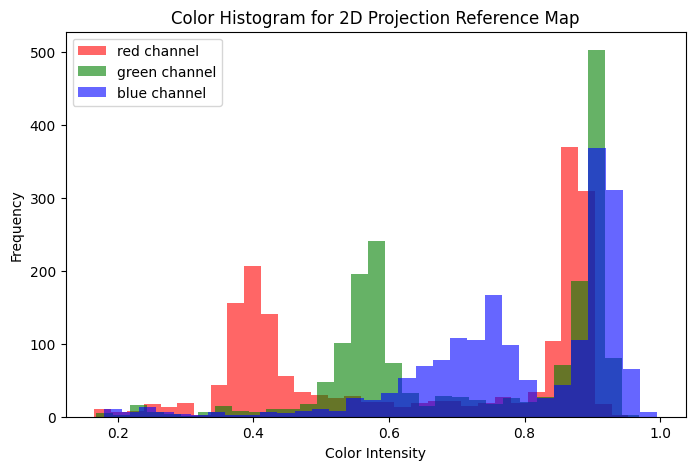

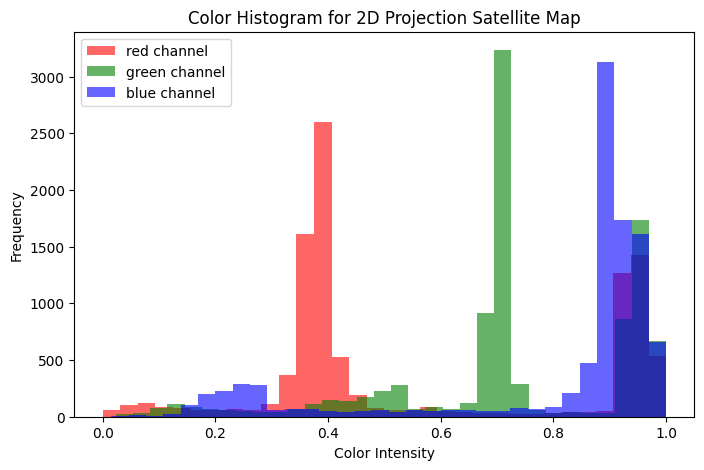

In [16]:
# Extract RGB channels for reference map
# rgb_spec_ref
# pts_spec_ref
# rgb_spec_sat
# pts_spec_sat


r_values_ref = [p[0] for p in rgb_spec_ref]
g_values_ref = [p[1] for p in rgb_spec_ref]
b_values_ref = [p[2] for p in rgb_spec_ref]

# Extract RGB channels for satellite map
r_values_sat = [p[0] for p in rgb_spec_sat]
g_values_sat = [p[1] for p in rgb_spec_sat]
b_values_sat = [p[2] for p in rgb_spec_sat]

# Define colors
colors = ['red', 'green', 'blue']

# Plot histogram for reference map
plt.figure(figsize=(8, 5))
for val, color in zip([r_values_ref, g_values_ref, b_values_ref], colors):
    plt.hist(val, bins=32, color=color, alpha=0.6, label=f"{color} channel")

plt.xlabel("Color Intensity")
plt.ylabel("Frequency")
plt.title("Color Histogram for 2D Projection Reference Map")
plt.legend()
plt.show()

# Plot histogram for satellite map
plt.figure(figsize=(8, 5))
for val, color in zip([r_values_sat, g_values_sat, b_values_sat], colors):
    plt.hist(val, bins=32, color=color, alpha=0.6, label=f"{color} channel")

plt.xlabel("Color Intensity")
plt.ylabel("Frequency")
plt.title("Color Histogram for 2D Projection Satellite Map")
plt.legend()
plt.show()


In [ ]:
# # Define output image size
# H, W = vox_size, vox_size
# img = np.zeros((H, W, 3), dtype=np.uint8)


# # Normalize (x, y) coordinates to image space
# x_min, x_max = pts_spec_sat[:, 0].min(), pts_spec_sat[:, 0].max()
# y_min, y_max = pts_spec_sat[:, 1].min(), pts_spec_sat[:, 1].max()

# # Debugging: Check range of x and y
# print(f"x_min: {x_min}, x_max: {x_max}")
# print(f"y_min: {y_min}, y_max: {y_max}")

# # Normalize coordinates to fit within image size
# x_norm = np.clip(((pts_spec_sat[:, 0] - x_min) / (x_max - x_min) * (W - 1)).astype(int), 0, W-1)
# y_norm = np.clip(((pts_spec_sat[:, 1] - y_min) / (y_max - y_min) * (H - 1)).astype(int), 0, H-1)

# # Debugging: Check range of normalized coordinates
# print(f"x_norm range: {x_norm.min()} to {x_norm.max()}")
# print(f"y_norm range: {y_norm.min()} to {y_norm.max()}")

# # Assign colors to corresponding pixels using the actual rgb_spec_sat
# for i in range(len(pts_spec_sat)):
#     # Ensure RGB values are scaled between 0 and 255
#     color = np.clip(rgb_spec_sat[i] * 255, 0, 255).astype(int)
    
#     # If multiple points are assigned to the same pixel, you can blend colors (for now, let's just overwrite)
#     img[y_norm[i], x_norm[i]] = color

# # Optionally fill empty pixels (those that remain black) with a default color like white
# img[img.sum(axis=-1) == 0] = [255, 255, 255]  # Fill empty pixels with white

# # Show the generated image
# plt.imshow(img)
# plt.title("Projected 2D Image from 3D Points")
# plt.show()

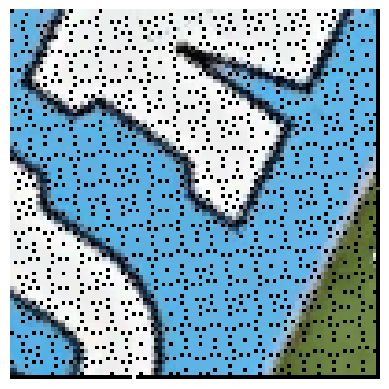

In [49]:
# # Initialize an empty grid for the image (all black initially)
image_rgb = np.zeros((vox_size, vox_size, 3), dtype=int)

# Extract x and y coordinates from pts_spec_sat (ignore the z-coordinate)
pts_2d = pts_spec_sat[:, :2]

# Shift the coordinates to start from 0 and then scale them
min_x, min_y = np.min(pts_2d, axis=0)  # Find the min values in x and y
# print(min_x, min_y)
max_x, max_y = np.max(pts_2d, axis=0)  # Find the max values in x and y
# print(max_x, max_y)

# Shift and scale the coordinates
for i in range(pts_2d.shape[0]):
    x, y = pts_2d[i]
    # print(x,y)
    
    # Shift the coordinates to be non-negative
    x_shifted = x - min_x
    # print(x_shifted)
    y_shifted = y - min_y
    
    # Scale the coordinates to fit into the grid (0 to vox_size-1)
    x_idx = int(np.clip((x_shifted / (max_x - min_x)) * (vox_size - 1), 0, vox_size - 1))
    y_idx = int(np.clip((y_shifted / (max_y - min_y)) * (vox_size - 1), 0, vox_size - 1))
    # print(x_idx, y_idx)
    # Assign the corresponding RGB value to the pixel in the grid
    image_rgb[y_idx, x_idx] = rgb_spec_sat[i]*255

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [50]:
print(rgb_spec_sat.shape[0])

9999


In [51]:
print(image_rgb)

[[[  0   0   0]
  [103 180 226]
  [105 179 226]
  ...
  [100 171 223]
  [ 50 113 164]
  [  0   0   0]]

 [[102 180 226]
  [100 178 224]
  [101 180 223]
  ...
  [ 92 162 214]
  [ 61 131 180]
  [  0   0   0]]

 [[102 180 226]
  [101 179 225]
  [ 99 180 223]
  ...
  [100 178 227]
  [ 97 170 215]
  [  0   0   0]]

 ...

 [[ 24  55  83]
  [ 39  70  98]
  [110 163 197]
  ...
  [111 133  69]
  [111 133  69]
  [  0   0   0]]

 [[ 11  32  53]
  [  6  23  39]
  [ 34  66  91]
  ...
  [111 133  69]
  [110 132  68]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


# Plotting Tools

In [ ]:
# # Use open3d to create point cloud visualization 

# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with origin")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

# # Create point cloud for scene pts
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(ref_scene)
# scene_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOT FOR ORIGINAL AND FIRST GUESS CLOUD 

# # Use open3d to create point cloud visualization 

# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with origin")

# # Create axes @ origin
# # axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for reference cloud
# ref_cloud = o3d.geometry.PointCloud()
# ref_cloud.points = o3d.utility.Vector3dVector(ref_scene)
# ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# # Create point cloud for satellite image
# sat_cloud = o3d.geometry.PointCloud()
# sat_cloud.points = o3d.utility.Vector3dVector(sat_pts)
# sat_cloud.colors = o3d.utility.Vector3dVector(sat_rgb)

# # Create point cloud for satellite image
# sat_cloudN = o3d.geometry.PointCloud()
# sat_cloudN.points = o3d.utility.Vector3dVector(sat_pts_n)
# sat_cloudN.colors = o3d.utility.Vector3dVector(sat_rgb)

# # Add necessary geometries to visualization 
# vis.add_geometry(ref_cloud)
# # vis.add_geometry(sat_cloud)
# vis.add_geometry(sat_cloudN)
# # vis.add_geometry(axis_origin)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # PLOT NEW POINTS 

# vis = o3d.visualization.Visualizer()
# vis.create_window()

# # Add coordinate axes
# # axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100)
# # axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)


# # cloud_2d = o3d.geometry.PointCloud()
# # cloud_2d.points = o3d.utility.Vector3dVector(pts_2d)
# # # cloud_2d.paint_uniform_color([0, 0, 1])
# # cloud_2d.colors = o3d.utility.Vector3dVector(camera_pts_rgb)

# # Add necessary geometries
# # vis.add_geometry(axis_origin)
# vis.add_geometry(ref_cloud)
# vis.add_geometry(sat_cloud)


# render_option = vis.get_render_option()
# render_option.point_size = 2

# vis.poll_events()
# vis.update_renderer()

# # Set up initial viewpoint
# view_control = vis.get_view_control()
# # Direction which the camera is looking
# view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # Point which the camera revolves about 
# view_control.set_lookat([0, 0, 0])   # Set the focus point
# # Defines which way is up in the camera perspective 
# view_control.set_up([-1, 0, 0])       # Set the up direction
# view_control.set_zoom(2)           # Adjust zoom if necessary


# # Capture frames for GIF
# frames = []
# num_frames = 30  # Adjust the number of frames
# angle_step = 180/num_frames


# for i in range(num_frames):
# 	# Rotate the view
#     view_control.rotate(angle_step, 0)  # (horizontal, vertical)

#     # vis.update_geometry(axis_orig) # Only if I move it myself?
#     vis.poll_events()
#     vis.update_renderer()

#     # Capture frame directly into memory
#     image = vis.capture_screen_float_buffer(False)
#     image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
#     frames.append(image_8bit)

# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(-angle_step, 0)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)

# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(-angle_step, 0)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)
    
# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(angle_step, 0)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)



# # Create GIF
# # Ensure frames are in the correct format
# frames = [frame.astype("uint8") for frame in frames]

# # Use imageio to save as GIF
# imageio.mimsave("cNDT_initial.gif", frames, fps=30, loop=0)  # Adjust fps if necessary

# # Run visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# PLOT FOR ORIGINAL AND SATELLITE - SPECIFIC VOXEL

# Use open3d to create point cloud visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Originial scene with origin")

# Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200)

# Create point cloud for reference cloud
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(ref_scene)
ref_cloud.colors = o3d.utility.Vector3dVector(ref_rgb)

# Create point cloud for satellite image
sat_cloudN = o3d.geometry.PointCloud()
sat_cloudN.points = o3d.utility.Vector3dVector(sat_pts_n)
sat_cloudN.colors = o3d.utility.Vector3dVector(sat_rgb)

# Create a cloud for specific voxel selection - REFERENCE CLOUD
spec_vox_r = o3d.geometry.PointCloud()
spec_vox_r.points = o3d.utility.Vector3dVector(pts_spec_ref)
spec_vox_r.paint_uniform_color([1,0,0]) # Paint same color

# Create a cloud for specific voxel selection - SATELLITE CLOUD
spec_vox_s = o3d.geometry.PointCloud()
spec_vox_s.points = o3d.utility.Vector3dVector(pts_spec_sat)
spec_vox_s.paint_uniform_color([1,0,0]) # Paint same color

# Add necessary geometries to visualization 
vis.add_geometry(ref_cloud)
vis.add_geometry(sat_cloudN)
vis.add_geometry(spec_vox_r)
# vis.add_geometry(spec_vox_s)
# vis.add_geometry(axis_origin)


# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# view_control = vis.get_view_control()
# view_control.set_zoom(4)           # Adjust zoom if necessary


# Run and destroy visualization 
vis.run()
vis.destroy_window()